In [1]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import colorcet
import matplotlib as mpl
from itertools import cycle
from reproject import reproject_interp
import imageio.v3 as iio
from astropy.visualization import wcsaxes

import warnings
warnings.filterwarnings('ignore')   

plt.style.use('paper.mplstyle')

In [2]:
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from regions import Regions, RectangleSkyRegion, CircleSkyRegion, EllipseSkyRegion

def get_croppeddata(hdu, ra, dec, width, height):
    """
    Function to crop data from an HDU object based on the provided region properties.

    Parameters:
        hdu (astropy.io.fits.ImageHDU): The input HDU object.
        i (int): Index of the region in the regions dictionary.
        regions (dict): Dictionary containing region properties.

    Returns:
        astropy.io.fits.ImageHDU: The cropped HDU object.
    """
    
    hdu_crop = hdu.copy()  # Copy the HDU object to avoid modifying the original data
    wcs = WCS(hdu_crop)  # Create a WCS object from the HDU header

    centre = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')  # Create a SkyCoord object for the center of the region
    cutout = Cutout2D(hdu_crop.data, centre, [width*u.deg*1.2, height*u.deg*1.2], wcs=wcs)  # Create a rectangular cutout
    hdu_crop = fits.PrimaryHDU(cutout.data, cutout.wcs.to_header())
    
    del hdu 
    del cutout  # Delete the cutout to free up memory

    return hdu_crop  # Return the cropped HDU object

def get_regions(regions_file):
    """
    Extracts region properties from a regions file and converts coordinates to image coordinates.

    Args:
        regions_file (str): Path to the regions file.

    Returns:
        dict: Dictionary containing region properties.

    """
    print(f'[INFO] [get_regions] Opening regions file (this may take a min)... ')
    # regions = pyregion.open(regions_file).as_imagecoord(header)
    regions = Regions.read(regions_file)
    n = len(regions)

    # Initialize empty arrays for storing region properties
    ra = np.empty(n) * np.nan * u.deg
    dec = np.empty(n) * np.nan * u.deg
    radius = np.empty(n) * np.nan * u.deg

    print(f'[INFO] [get_regions] Getting info for {n} regions...')

    for i, region in enumerate(regions):
        # Extract the region properties and store them in the respective arrays
        ra[i] = float(region.center.ra.deg) * u.deg
        dec[i] = float(region.center.dec.deg) * u.deg
        radius[i] = (region.width + region.height) / 2

    # Create a SkyCoord object for the positions
    position = SkyCoord(ra=ra, dec=dec, frame='icrs')

    # Return a dictionary containing the region properties
    return ra.value, dec.value, radius.value, radius.value, n

In [3]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'

file_mus = '%s/data_hstha/ngc1566/muse/NGC1566-0.80asec_MAPS.fits' %root_dir 
file_hst = '%s/data_hstha/ngc1566/hst_contsub/ngc1566_hst_ha_sic.fits' %root_dir 
file_hstcat = '%s/data_hstha_nebulae_catalogue/ngc1566/catalogue/ngc1566_mask.fits' %root_dir 
file_hstcpx = '%s/data_hstha_nebulae_catalogue/ngc1566/catalogue/ngc1566_complexity.fits' %root_dir 
# file_muscat = '%s/data_hstha/ngc1566/muse/NGC1566_nebmask.fits' %root_dir 
file_muscat = '%s/data_hstha/ngc1566/hst_contsub/ngc1566_muse_nebmask_regrid.fits' %root_dir 

# Roated the JWST image to match the orientation of the MUSE and HST images
# sips -r 5.5 --padColor FFFFFF STScI-01HNGA39FNN541ZAF484AMYSDR.png -o jwst_hst_rotated.png
# sips -r 5.5 --padColor FFFFFF STScI-01HMA01C49P3TD74277KABGZSG.png -o jwst_rotated.png
# sips -r 5.5 --padColor FFFFFF STScI-01HM9ZT72EHPYSDHWW5D9N8J9Y.png -o hst_rotated.png

file_jwst = '%s/data_hstha/ngc1566/jwst/ngc1566_nircam_lv3_f300m_i2d_anchor.fits' %root_dir 
file_jwst_png = '%s/data_hstha/ngc1566/rgb/jwst_rotated.png' %root_dir
file_hst_png = '%s/data_hstha/ngc1566/rgb/hst_rotated.png' %root_dir

hdu_mus = fits.open(file_mus)['HA6562_FLUX']
hdu_hst = fits.open(file_hst)[0]
hdu_hstcat = fits.open(file_hstcat)[0]
# hdu_muscat = fits.open(file_muscat)[0]
hdu_hstcpx = fits.open(file_hstcpx)[0]

hdu_jwst = fits.open(file_jwst)[1]

hdu_hstcat_masked = fits.open(file_hstcat)[0]
hdu_muscat_masked = fits.open(file_muscat)[0]

hdu_hstcat_masked.data = np.array(hdu_hstcat_masked.data, dtype=float)
hdu_muscat_masked.data = np.array(hdu_muscat_masked.data, dtype=float)

# hdu_hstcat_masked.data[hdu_hstcat_masked.data==-1] = np.nan
# hdu_muscat_masked.data[hdu_muscat_masked.data==-1] = np.nan

hdu_muscat = hdu_muscat_masked.copy()
hdu_muscat.data[np.isnan(hdu_muscat.data)] = -1

# Convert to units of 1e-15 erg/s/cm2/arcsec2
hdu_mus.data = hdu_mus.data * (1/(hdu_mus.header['CD2_2']*3600)**2)
hdu_hst.data = hdu_hst.data * (1/(hdu_hst.header['CD2_2']*3600)**2)
hdu_mus.data = hdu_mus.data / 1e5
hdu_hst.data = hdu_hst.data / 1e5

In [4]:
regions_file = './regs/nebs_simple.reg'
centres_x, centres_y, widths, heights, n = get_regions(regions_file)
n = len(centres_x)

hdu_mus_crop = []
hdu_hst_crop = []
hdu_muscat_crop = []
hdu_hstcat_crop = []
hdu_hstcpx_crop = []

for i, (centre_x, centre_y, width, height) in enumerate(zip(centres_x, centres_y, widths, heights)):

    hdu_mus_crop += [get_croppeddata(hdu_mus, centre_x, centre_y, width, height)]
    hdu_hst_crop += [get_croppeddata(hdu_hst, centre_x, centre_y, width, height)]
    hdu_muscat_crop += [get_croppeddata(hdu_muscat, centre_x, centre_y, width, height)]
    hdu_hstcat_crop += [get_croppeddata(hdu_hstcat, centre_x, centre_y, width, height)]
    hdu_hstcpx_crop += [get_croppeddata(hdu_hstcpx, centre_x, centre_y, width, height)]

[INFO] [get_regions] Opening regions file (this may take a min)... 
[INFO] [get_regions] Getting info for 4 regions...


In [5]:
# Deinfe colours
cmap1 = plt.cm.binary(np.linspace(0, 1, 32))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 128))
cmaplist = np.vstack((cmap1, cmap2))
cmap_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap_map.set_under(cmap_map(0))
cmap_map.set_bad(color=cmap_map(0))

# Deinfe colours
cmap_cat = plt.get_cmap('turbo')
cmap_cat.set_under('lightgrey')
cmap_cat.set_bad('lightgrey')

# Deinfe colours
cmap_cpx = plt.get_cmap('viridis', 5)
cmap_cpx.set_under('lightgrey')
cmap_cpx.set_bad('lightgrey')

finished running


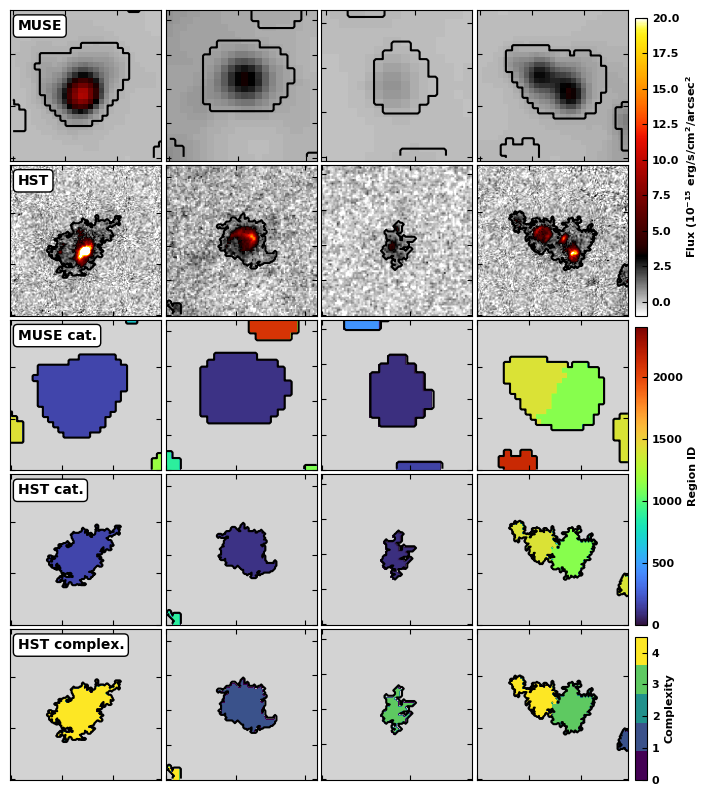

In [6]:
fig = plt.figure(figsize=(9, 10)) 
fig.subplots_adjust(wspace=-0.325, hspace=0.025)

for i in range(len(hdu_mus_crop)):

    centre_x = centres_x[i]
    centre_y = centres_y[i]
    width = widths[i]
    height = heights[i]

    j = i+1

    ax1 = fig.add_subplot(5,n,j)
    ax2 = fig.add_subplot(5,n,j+n)
    ax3 = fig.add_subplot(5,n,j+(2*n))
    ax4 = fig.add_subplot(5,n,j+(3*n))
    ax5 = fig.add_subplot(5,n,j+(4*n))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin5, vmax5 = np.nanpercentile(hdu_hstcpx_crop[i].data, [0,100])

    ax1.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5, extent=[0, hdu_mus_crop[i].data.shape[0], 0, hdu_mus_crop[i].data.shape[1]])
    ax2.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax3.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax4.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax5.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)

    im1 = ax1.imshow(hdu_mus_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im2 = ax2.imshow(hdu_hst_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im3 = ax3.imshow(hdu_muscat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im4 = ax4.imshow(hdu_hstcat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im5 = ax5.imshow(hdu_hstcpx_crop[i].data, cmap=cmap_cpx, vmin=0, vmax=4.5, origin='lower')

    for ax in [ax1, ax2, ax3, ax4, ax5]: 

        ax.set_xticklabels([])
        ax.set_yticklabels([])

    if i == 0:
        ax1.text(0.05, 0.94, 'MUSE', transform=ax1.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.text(0.05, 0.94, 'HST', transform=ax2.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.text(0.05, 0.94, 'MUSE cat.', transform=ax3.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.text(0.05, 0.94, 'HST cat.', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.text(0.05, 0.94, 'HST complex.', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

    if i == n-1: 

        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
        cbar.set_label('Flux ($10^{-15}$ erg/s/cm$^2$/arcsec$^2$', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos1 = ax3.get_position()
        pos2 = ax4.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
        cbar.set_label('Region ID', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos = ax5.get_position()
        cax = fig.add_axes([pos.x1+pos.width*0.05, pos.y0, pos.width*0.075, pos.height-pos.height*0.05])
        cbar = fig.colorbar(im5, cax=cax, orientation='vertical')
        cbar.set_label('Complexity', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)
        
print('finished running')

finished running


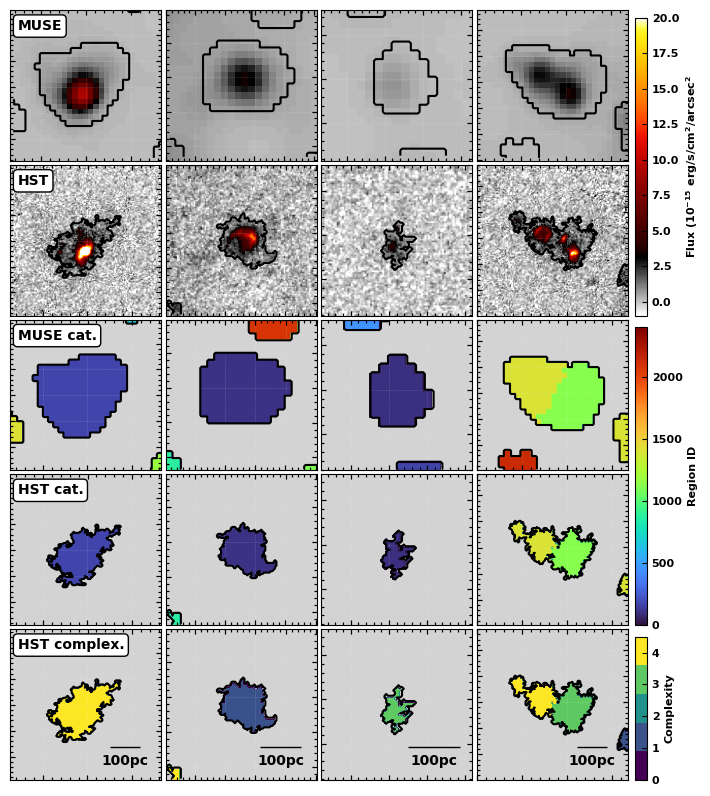

In [7]:
fig = plt.figure(figsize=(9, 10)) 
fig.subplots_adjust(wspace=-0.325, hspace=0.025)

for i in range(len(hdu_mus_crop)):

    centre_x = centres_x[i]
    centre_y = centres_y[i]
    width = widths[i]
    height = heights[i]

    j = i+1

    ax1 = fig.add_subplot(5,n,j, projection=WCS(hdu_mus_crop[i].header))
    ax2 = fig.add_subplot(5,n,j+n, projection=WCS(hdu_hst_crop[i].header))
    ax3 = fig.add_subplot(5,n,j+(2*n), projection=WCS(hdu_muscat_crop[i].header))
    ax4 = fig.add_subplot(5,n,j+(3*n), projection=WCS(hdu_hstcat_crop[i].header))
    ax5 = fig.add_subplot(5,n,j+(4*n), projection=WCS(hdu_hstcpx_crop[i].header))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin5, vmax5 = np.nanpercentile(hdu_hstcpx_crop[i].data, [0,100])

    ax1.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5, extent=[0, hdu_mus_crop[i].data.shape[0], 0, hdu_mus_crop[i].data.shape[1]])
    ax2.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax3.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax4.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax5.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)

    im1 = ax1.imshow(hdu_mus_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im2 = ax2.imshow(hdu_hst_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im3 = ax3.imshow(hdu_muscat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im4 = ax4.imshow(hdu_hstcat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im5 = ax5.imshow(hdu_hstcpx_crop[i].data, cmap=cmap_cpx, vmin=0, vmax=4.5, origin='lower')

    for ax in [ax1, ax2, ax3, ax4, ax5]: 

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.tick_params(axis='x', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(axis='y', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.grid(True, color='white', linestyle=':', linewidth=0.5, alpha=0.3)

        ra = ax.coords[0]
        dec = ax.coords[1]

        ra.display_minor_ticks(True)
        dec.display_minor_ticks(True)

    if i == 0:
        ax1.text(0.05, 0.94, 'MUSE', transform=ax1.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.text(0.05, 0.94, 'HST', transform=ax2.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.text(0.05, 0.94, 'MUSE cat.', transform=ax3.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.text(0.05, 0.94, 'HST cat.', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.text(0.05, 0.94, 'HST complex.', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

    wcsaxes.add_scalebar(ax5, (100/(17.7e6/206265)*u.arcsec).to('deg'), corner='bottom right', label='100pc')

    if i == n-1: 

        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
        cbar.set_label('Flux ($10^{-15}$ erg/s/cm$^2$/arcsec$^2$', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos1 = ax3.get_position()
        pos2 = ax4.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
        cbar.set_label('Region ID', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos = ax5.get_position()
        cax = fig.add_axes([pos.x1+pos.width*0.05, pos.y0, pos.width*0.075, pos.height-pos.height*0.05])
        cbar = fig.colorbar(im5, cax=cax, orientation='vertical')
        cbar.set_label('Complexity', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)
        
print('finished running')
plt.savefig('./figs/maps_hstmuse_ngc1566_zoom_simple.pdf', dpi=150, bbox_inches='tight', transparent=True)

In [8]:
regions_file = './regs/nebs_complex.reg'
centres_x, centres_y, widths, heights, n = get_regions(regions_file)
n = len(centres_x)

hdu_mus_crop = []
hdu_hst_crop = []
hdu_muscat_crop = []
hdu_hstcat_crop = []
hdu_hstcpx_crop = []

for i, (centre_x, centre_y, width, height) in enumerate(zip(centres_x, centres_y, widths, heights)):

    hdu_mus_crop += [get_croppeddata(hdu_mus, centre_x, centre_y, width, height)]
    hdu_hst_crop += [get_croppeddata(hdu_hst, centre_x, centre_y, width, height)]
    hdu_muscat_crop += [get_croppeddata(hdu_muscat, centre_x, centre_y, width, height)]
    hdu_hstcat_crop += [get_croppeddata(hdu_hstcat, centre_x, centre_y, width, height)]
    hdu_hstcpx_crop += [get_croppeddata(hdu_hstcpx, centre_x, centre_y, width, height)]

[INFO] [get_regions] Opening regions file (this may take a min)... 
[INFO] [get_regions] Getting info for 4 regions...


In [9]:
# Deinfe colours
cmap1 = plt.cm.binary(np.linspace(0, 1, 32))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 128))
cmaplist = np.vstack((cmap1, cmap2))
cmap_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap_map.set_under(cmap_map(0))
cmap_map.set_bad(color=cmap_map(0))

# Deinfe colours
cmap_cat = plt.get_cmap('turbo')
cmap_cat.set_under('lightgrey')
cmap_cat.set_bad('lightgrey')

# Deinfe colours
cmap_cpx = plt.get_cmap('viridis', 30)
cmap_cpx.set_under('lightgrey')
cmap_cpx.set_bad('lightgrey')

finished running


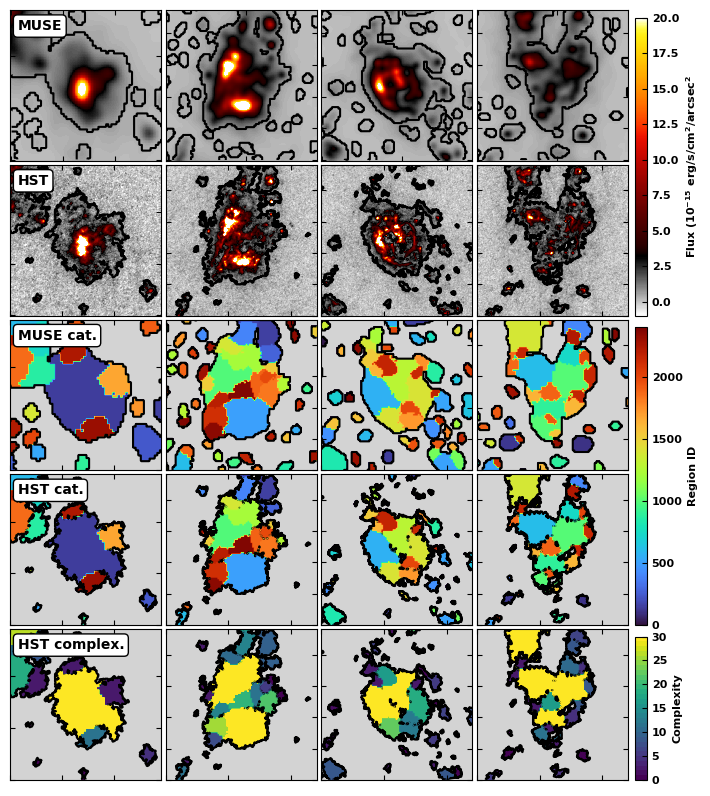

In [10]:
fig = plt.figure(figsize=(9, 10)) 
fig.subplots_adjust(wspace=-0.325, hspace=0.025)

for i in range(len(hdu_mus_crop)):

    centre_x = centres_x[i]
    centre_y = centres_y[i]
    width = widths[i]
    height = heights[i]

    j = i+1

    ax1 = fig.add_subplot(5,n,j)
    ax2 = fig.add_subplot(5,n,j+n)
    ax3 = fig.add_subplot(5,n,j+(2*n))
    ax4 = fig.add_subplot(5,n,j+(3*n))
    ax5 = fig.add_subplot(5,n,j+(4*n))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin5, vmax5 = np.nanpercentile(hdu_hstcpx_crop[i].data, [0,100])

    ax1.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5, extent=[0, hdu_mus_crop[i].data.shape[0], 0, hdu_mus_crop[i].data.shape[1]])
    ax2.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax3.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax4.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)
    ax5.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1.5)

    im1 = ax1.imshow(hdu_mus_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im2 = ax2.imshow(hdu_hst_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im3 = ax3.imshow(hdu_muscat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im4 = ax4.imshow(hdu_hstcat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im5 = ax5.imshow(hdu_hstcpx_crop[i].data, cmap=cmap_cpx, vmin=0, vmax=30, origin='lower')

    for ax in [ax1, ax2, ax3, ax4, ax5]: 

        ax.set_xticklabels([])
        ax.set_yticklabels([])

    if i == 0:
        ax1.text(0.05, 0.94, 'MUSE', transform=ax1.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.text(0.05, 0.94, 'HST', transform=ax2.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.text(0.05, 0.94, 'MUSE cat.', transform=ax3.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.text(0.05, 0.94, 'HST cat.', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.text(0.05, 0.94, 'HST complex.', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

    if i == n-1: 

        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
        cbar.set_label('Flux ($10^{-15}$ erg/s/cm$^2$/arcsec$^2$', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos1 = ax3.get_position()
        pos2 = ax4.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
        cbar.set_label('Region ID', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos = ax5.get_position()
        cax = fig.add_axes([pos.x1+pos.width*0.05, pos.y0, pos.width*0.075, pos.height-pos.height*0.05])
        cbar = fig.colorbar(im5, cax=cax, orientation='vertical')
        cbar.set_label('Complexity', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)
        
print('finished running')

finished running


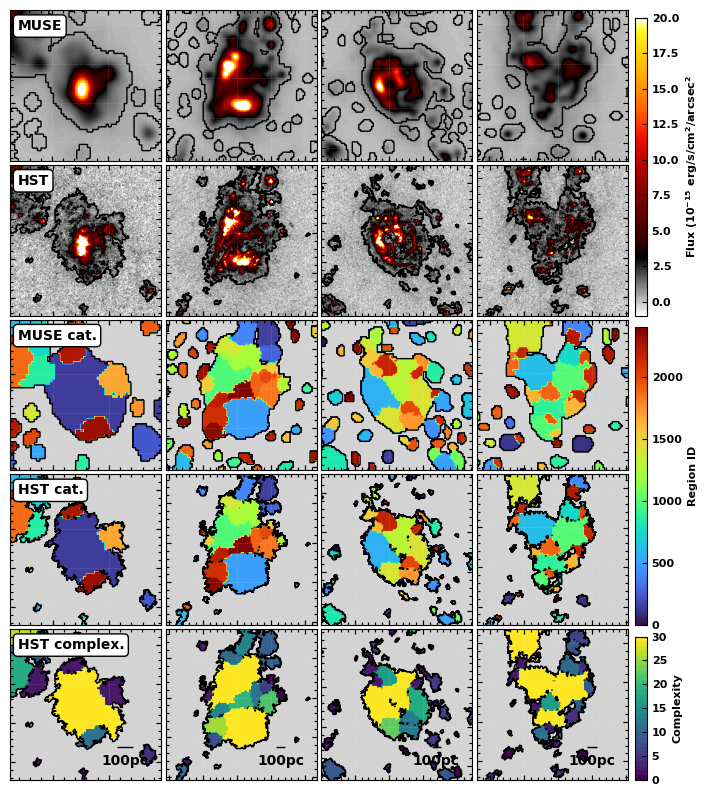

In [11]:
fig = plt.figure(figsize=(9, 10)) 
fig.subplots_adjust(wspace=-0.325, hspace=0.025)

for i in range(len(hdu_mus_crop)):

    centre_x = centres_x[i]
    centre_y = centres_y[i]
    width = widths[i]
    height = heights[i]

    j = i+1

    ax1 = fig.add_subplot(5,n,j, projection=WCS(hdu_mus_crop[i].header))
    ax2 = fig.add_subplot(5,n,j+n, projection=WCS(hdu_hst_crop[i].header))
    ax3 = fig.add_subplot(5,n,j+(2*n), projection=WCS(hdu_muscat_crop[i].header))
    ax4 = fig.add_subplot(5,n,j+(3*n), projection=WCS(hdu_hstcat_crop[i].header))
    ax5 = fig.add_subplot(5,n,j+(4*n), projection=WCS(hdu_hstcpx_crop[i].header))

    vmin1, vmax1 = np.nanpercentile(hdu_mus.data, [1, 99.95])
    vmin3, vmax3 = np.nanpercentile(hdu_muscat.data, [0,100])
    vmin5, vmax5 = np.nanpercentile(hdu_hstcpx_crop[i].data, [0,100])

    ax1.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1, extent=[0, hdu_mus_crop[i].data.shape[0], 0, hdu_mus_crop[i].data.shape[1]])
    ax2.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1)
    ax3.contour(hdu_muscat_crop[i].data, [0], origin='lower', colors='black', linewidths=1)
    ax4.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1)
    ax5.contour(hdu_hstcat_crop[i].data, [0], origin='lower', colors='black', linewidths=1)

    im1 = ax1.imshow(hdu_mus_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im2 = ax2.imshow(hdu_hst_crop[i].data, cmap=cmap_map, vmin=-1, vmax=20, origin='lower')
    im3 = ax3.imshow(hdu_muscat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im4 = ax4.imshow(hdu_hstcat_crop[i].data, cmap=cmap_cat, vmin=0, vmax=vmax3, origin='lower')
    im5 = ax5.imshow(hdu_hstcpx_crop[i].data, cmap=cmap_cpx, vmin=0, vmax=30, origin='lower')

    for ax in [ax1, ax2, ax3, ax4, ax5]: 

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.tick_params(axis='x', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='y', which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(axis='y', labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.grid(True, color='white', linestyle=':', linewidth=0.5, alpha=0.3)

        ra = ax.coords[0]
        dec = ax.coords[1]

        ra.display_minor_ticks(True)
        dec.display_minor_ticks(True)

    if i == 0:
        ax1.text(0.05, 0.94, 'MUSE', transform=ax1.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax2.text(0.05, 0.94, 'HST', transform=ax2.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax3.text(0.05, 0.94, 'MUSE cat.', transform=ax3.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax4.text(0.05, 0.94, 'HST cat.', transform=ax4.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')
        ax5.text(0.05, 0.94, 'HST complex.', transform=ax5.transAxes, color='black', bbox=dict(facecolor='white', boxstyle='round', alpha=1), size=10, ha='left', va='top')

    wcsaxes.add_scalebar(ax5, (100/(17.7e6/206265)*u.arcsec).to('deg'), corner='bottom right', label='100pc')

    if i == n-1: 

        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im1, cax=cax, orientation='vertical')
        cbar.set_label('Flux ($10^{-15}$ erg/s/cm$^2$/arcsec$^2$', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos1 = ax3.get_position()
        pos2 = ax4.get_position()
        cax = fig.add_axes([pos2.x1+pos2.width*0.05, pos2.y0, pos2.width*0.075, pos1.y1-pos2.y0-pos2.height*0.05])
        cbar = fig.colorbar(im3, cax=cax, orientation='vertical')
        cbar.set_label('Region ID', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)

        pos = ax5.get_position()
        cax = fig.add_axes([pos.x1+pos.width*0.05, pos.y0, pos.width*0.075, pos.height-pos.height*0.05])
        cbar = fig.colorbar(im5, cax=cax, orientation='vertical')
        cbar.set_label('Complexity', fontsize=8)
        cbar.ax.tick_params(axis='both', which='major', labelsize=8)
        
print('finished running')
plt.savefig('./figs/maps_hstmuse_ngc1566_zoom_complex.pdf', dpi=150, bbox_inches='tight', transparent=True)